In [5]:
#The goal is to sum all the counts of the detector over the all steps and plot them against the power.
#The dependence in case of different attenuation mechanisms is linear and quadratic.

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import statistics
import math  
import os, sys
import pandas as pd

#s={}
#l={}
stds={}
stdl={}
stdd={}
stdd_sum={}
stdl_sum={}
stds_sum={}



##calculate the sum over step in Z-scan for dark values

#function for mean calculation - input is path to the file with data, 
#start,stop and step of the trasnslation stage, number of measurements

def Z_scan_sum (path, start, stop, scan_step, measurements):
    
    step=[]
    outputpd={}
    raw=[]
    d={}
    std={}
    std_sum={}
    
    step=np.arange(start, stop, scan_step).tolist() #generate a list of translation stage positions, use arange arguments to vary
#loop through all files in path and upload them one after other to raw list
    for filename in os.listdir(path):
        raw=np.loadtxt(path + '\\' + filename, skiprows=6).tolist()
#Dictionary initialization    
        d[filename]={}
        std[filename]={}
#Remove the stage position from and create a nested dictionary {filename:{stage position i:counts value}}
        for i in step:
            raw.remove (round(i,3))
            d[filename] [round(i,3)]= sum (raw[:measurements])
            std[filename] [round(i,3)]= np.std(raw[:measurements])
            del raw[:measurements]
        
#calculate the standard deviation    
    for filename in os.listdir(path):
        std_sum[filename]=0
        for i in step: 
            std_sum[filename] = math.sqrt((std[filename] [round(i,3)])**2 + (std_sum[filename])**2)    
    outputpd = pd.DataFrame(data=d)
    return outputpd, std_sum

measurements=100 #specifies how many measurements done per step

#calculate the sum over step in Z-scan  and stdev for dark values
path=r"C:\Users\sweet\Dropbox\Work\Python_script\Processing\LvsQRh6G\Dark" # Empty/dark files path
dark, stdd_sum = Z_scan_sum(path, 7.6, 7.799, 0.001, measurements)

#calculate the sum over step in Z-scan and stdev for for linear-attenuated values
path=r"C:\Users\sweet\Dropbox\Work\Python_script\Processing\LvsQRh6G\Linear"
lin, stdl_sum = Z_scan_sum(path, 7.6, 7.799, 0.001, measurements)
for filename in os.listdir(path):
    stdl_sum[filename] = math.sqrt((stdl_sum[filename])  + (list(stdd_sum.values())[0])**2)
    #print (stdl_sum[filename]/1000)
    
#calculate the sum over step in Z-scan for square-attenuated values
path=#set the path to your data here
sq, stds_sum = Z_scan_sum(path, 7.6, 7.799, 0.001, measurements)
for filename in os.listdir(path):
    stds_sum[filename] = math.sqrt((stds_sum[filename])  + (list(stdd_sum.values())[0])**2)
    #print (stds_sum[filename]/10000)


#calculate the total standard deviation for square-attenuated values after dark subtraction
stds = pd.DataFrame (data=stds)
stdl = pd.DataFrame (data=stdl)
stdark=pd.DataFrame (data=stdd)

#preparation of nparray for linear fit and R-square
linear_data = (lin.sum(axis=0).to_numpy()-dark.sum(axis=0).to_numpy())/10000
linear_data = np.append (0, linear_data)
row = np.array([0, 41, 78, 112, 139, 163]) #the values of SPDC power 
linear_data = np.vstack([row,linear_data])

#preparation of nparray for square fita and RMSE
square_data=(sq.sum(axis=0).to_numpy()-dark.sum(axis=0).to_numpy())/10000
stds_sum = pd.DataFrame (data=stds_sum, index=[0]).to_numpy()/square_data/10000
square_data = np.append (0, square_data)
square_data=np.sort(square_data)
rows = np.array([0, 31, 56, 77, 103, 163]) #SPDC power values
square_data = np.vstack([rows,square_data])

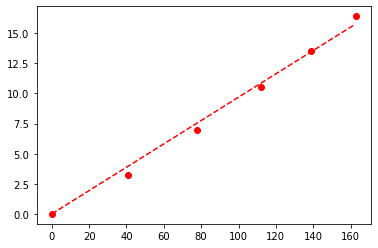

C:\Users\sweet\AppData\Local\Temp/ipykernel_11408/3958060020.py:37: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  zl = y_line [[zl1]]


R-squared: 0.997707


In [6]:
# fit a straight line to linear power attenuation data
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
from sklearn.metrics import r2_score
from scipy import stats

# define the true objective function
def line(x, a):
    return a * x
 
# load the dataset
# choose the input and output variables
xl, yl = linear_data
# curve fit
popt, _ = curve_fit(line, xl, yl)
# summarize the ameter values
a = popt
# plot input vs output
plt.scatter(xl, yl, color = 'red')
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(xl), max(xl), 1)
# calculate the output for the range
y_line = line(x_line, a)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '--', color='red')
plt.show()

#calculate r^2 for this line
zl1 = (0, 1, 2, 3, 4, 5)
zl = y_line [[zl1]]
res = stats.linregress(zl, yl)
print(f"R-squared: {res.rvalue**2:.6f}")

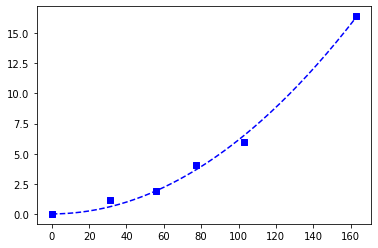

0.12067200303025583


C:\Users\sweet\AppData\Local\Temp/ipykernel_11408/1047271220.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  zs = y_square [[zs1]]


In [7]:
# fit a qudratic function to SPDC attenuation data

from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
from scipy.stats import chisquare

# define the true objective function
def square(x,b):
    return b * x**2
 
# load the dataset
xs, ys = square_data
# curve fit
popt, _ = curve_fit(square, xs, ys)
# summarize the parameter values
b = popt
#print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
# plot input vs output
plt.scatter(xs, ys, marker = 's', color = 'blue')
# define a sequence of inputs between the smallest and largest known inputs
x_square = arange(min(xs), max(xs), 1)
# calculate the output for the range
y_square = square(x_square, b)
# create a line plot for the mapping function
plt.plot(x_square, y_square, '--', color='blue')
plt.show()

zs1 = (0, 44, 55, 81, 99, 162)
zs = y_square [[zs1]]

MSE = np.square(np.subtract(zs,ys)).mean() 
 
RMSE = math.sqrt(MSE)
print (RMSE)


[0.         0.02766469 0.05263038 0.07557182 0.09379003 0.10998399]


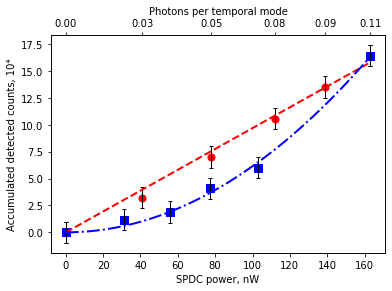

In [21]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)


plt.scatter(xl, yl, s=50,  color = 'red', label = 'Pump attenuation')
plt.errorbar(xl, yl, yerr=max(yl)*0.06, fmt=",", linewidth = 1, color='black',capsize = 2, capthick = 1)
plt.plot(x_line, y_line, '--', color='red', linewidth = 2, label = 'Linear fit')

plt.scatter(xs, ys, s=50, marker = 's', color = 'blue', label = 'Pair attenuation')
plt.errorbar(xs, ys, yerr=max(ys)*0.06, fmt=",", linewidth = 1, color='black',capsize = 2, capthick = 1)
plt.plot(x_square, y_square, '-.', color='blue', linewidth = 2, label = 'Quadratic fit')

plt.xlabel("SPDC power, nW") 
plt.ylabel("Accumulated detected counts, 10\u2074")

ax2 = ax1.twiny()

new_tick_locations = xl

def tick_function(X):
    V = 1.064e-6*xl/(6.62e-34)/3e8*1e-9/(7.94e12) #converts the values of x-axis into photons/temporal mode
    print (V)
    return ["%.2f" % z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Photons per temporal mode")
pyplot.show()

#### 